# PyTorch custom dataset

Used some datasets with PyTorch. Now using your own data. So custom datasets!!

## 0. Importing libs and device agnostic code

In [1]:
# Import required libs
import torch
from torch import nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:
!nvidia-smi

Sat Jul  5 21:22:36 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   38C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 1. Get Data

The dataset is a subset of Food101 dataset.

Foo101 has 101 different classes and 1000 images per class (750 train, 250 test images)

it start with 3 classes of food and only 10% of images.

Taking this dataset from github repo: `https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip`

In [3]:
# Get custom dataset
import requests
import zipfile
from pathlib import Path

# setup path to data folder to store data
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image path dosen't exis, download and prepare it
if image_path.is_dir():
  print(f"{image_path} directory exist. Skipping downalod.")
else:
  print(f"{image_path} directory dosen't exist, creating one.")
  image_path.mkdir(parents=True, exist_ok=True)

# Download the dataset
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading dataset")
  f.write(request.content)

# Unzip the dataset
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping dataset")
  zip_ref.extractall(image_path)

data/pizza_steak_sushi directory dosen't exist, creating one.
Unzipping dataset


## 2. Preprocessing and exploring data

In [4]:
import os
def walk_through_dir(dir_path):
  """
  Walks through dir path returning its contents
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

In [5]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'


In [6]:
# Setup train and testing paths

train_dir = image_path / "train"
test_dir = image_path / "test"

### 2.1 Visualizing image

1. Get all of the image paths
2. Pick a random image path using python's `random.choice()`
3. Get the image class name using `pathlib.Path.parent.stem`
4. Since we're working with python images we will use PIL
5. We'll then show image and print metadata

Random Image Path: data/pizza_steak_sushi/train/sushi/3426958.jpg
Image class: sushi
Image height: 512
Image width: 512


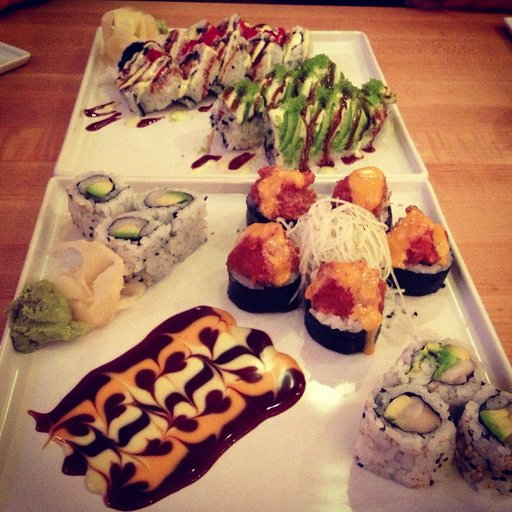

In [7]:

import random
from PIL import Image

# set seed
random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. picking random image to explore data
random_image_path = random.choice(image_path_list)
print(f"Random Image Path: {random_image_path}")

# 3. Get image class from path name (class is in path name - here sushi)
image_class = random_image_path.parent.stem
print(f"Image class: {image_class}")

# 4. Open Image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

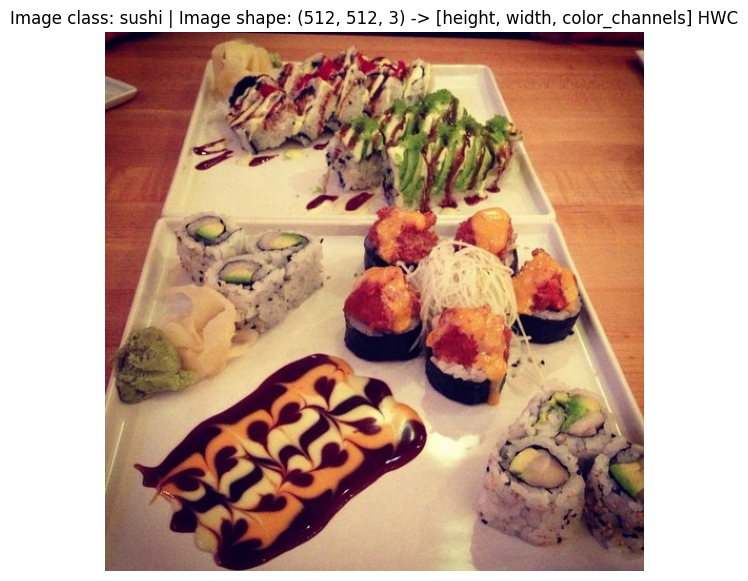

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Turn image into array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels] HWC")
plt.axis(False)

## 3. Transforming Data

Before we use our data with PyTorch:
1. Turn the target data into tensors (in this case, numerical representation of images)
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`

In [9]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transforms`

In [10]:
# Write a transform for image
data_transform = transforms.Compose([
    # Resize images to 64, 64
    transforms.Resize(size=(64, 64)),
    # Flip the images
    transforms.RandomHorizontalFlip(p=0.5), # probability of flip = 0.5 = 50%
    # Turn the image into Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
])


In [11]:
data_transform(img).shape

torch.Size([3, 64, 64])

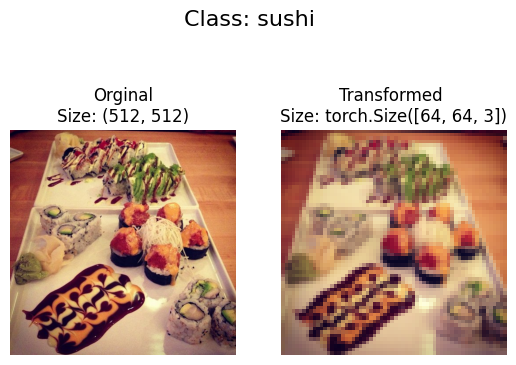

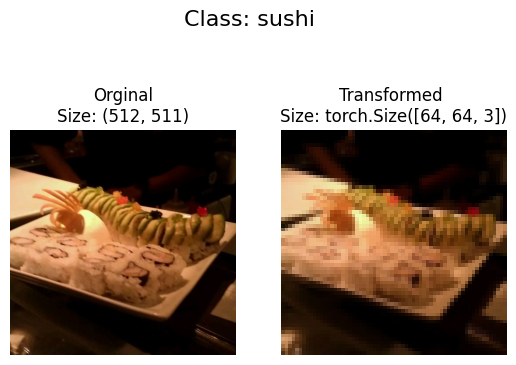

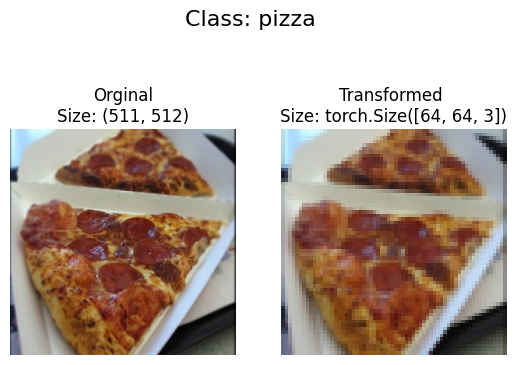

In [12]:
def plot_transformed_images(image_paths: list, transform, n=3, seed=None):
  """
  Select random images from a path of images and load/transforms them and then plot the original vs transformed images
  """
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows = 1, ncols = 2)
      ax[0].imshow(f)
      ax[0].set_title(f"Orginal\nSize: {f.size}")
      ax[0].axis(False)

      # Transform and plot target image
      # transformed_image = transform(f)
      transformed_image = transform(f).permute(1, 2, 0) # this will error out. As we need to change the shape to plot it. Tensors make it CHW, but plotting needs HWC
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
      ax[1].axis(False)

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=42)

## 4. Option 1: Loading Image data using `ImageFolder`

We can load image classification data using `torch.datasets.ImageFolder`

In [13]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, # a transform for the data
                                  target_transform=None) # a transform for the label/target

test_data = datasets.ImageFolder(root=test_dir,
                                transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [14]:
# Get class names as list
class_names = train_data.classes
print(class_names)
# Get class names as dict
class_dict = train_data.class_to_idx
print(class_dict)

['pizza', 'steak', 'sushi']
{'pizza': 0, 'steak': 1, 'sushi': 2}


In [15]:
# checking len of dataset
len(train_data), len(test_data)

(225, 75)

In [16]:
train_data.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)

In [17]:
# Index on train_data Dataset to get a single image and label
img, label = train_data[0]
print(f"Image Tensor:\n{img}")
print(f"Image Shape:\n{img.shape}")
print(f"Image Dtype:\n{img.dtype}")
print(f"Image Label:\n{label}")
print(f"Label Dtype:\n{type(label)}")

Image Tensor:
tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.01

In [18]:
class_names[label]

'pizza'

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute shape: torch.Size([64, 64, 3]) -> [height, width, color_channels]


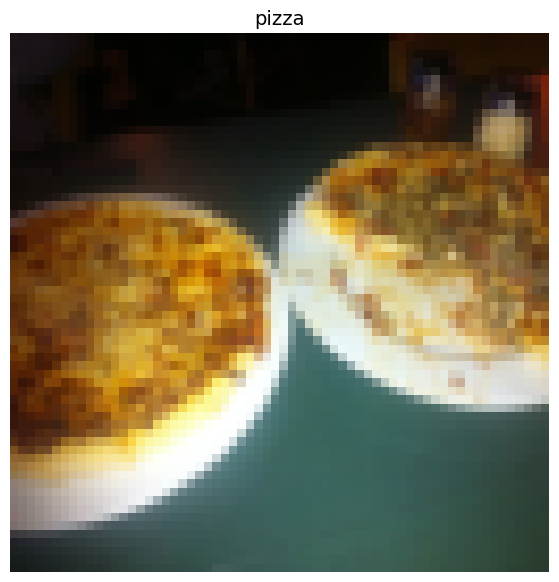

In [19]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis(False)
plt.title(class_names[label], fontsize=14);

### 4.1 Turn loaded images into `DataLoader`

A dataloader turns our `Dataset` into iterables and we can set the `bathc_size` so our model can see `batch_size` images at a time.

In [20]:
import os
os.cpu_count()

2

In [21]:
# Turn trian and test datasets into DataLoader

from torch.utils.data import DataLoader
BATCH_SIZE = 1

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=os.cpu_count(),
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7a21ea0f34d0>,
 <torch.utils.data.dataloader.DataLoader at 0x7a21ea1d7210>)

In [22]:
len(train_dataloader), len(test_dataloader)

(225, 75)

In [23]:
img, label = next(iter(train_dataloader))

# Batch size will be 1
print(f"Image shape: {img.shape} -> [batch_size, color_channel, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channel, height, width]
Label shape: torch.Size([1])


## 5. Option 2: Loading Image data with a custom `Dataset`

1. Want to be able to load images from file
2. Want to be able to get class names from dataset
3. Want to be able to get classes as dictionary from the dataset

Pros:
* Can create `Dataset` out of almost anything - as long as your code is correct
* Not limited to PyTorch pre-build `Dataset` fns

Cons:
* Even though you could create a `Dataset` out of almost anything, it doesn't mean it will work.
* Using a custom `Dataset` often results in writing more code, which could be prone to errors or performance issues.

All custom datasets in PyTorch, often subclass - `torch.utils.data.Dataset`

In [24]:
import os
import pathlib

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [25]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating helper functions to get class names

1. Get class names using `os.scandir` to traverse a target dir (ideally the directory is in standard image classification format)
2. Raise an error if the class names arent found (if this happpens, there might be something wrong with tha data)
3. Turn the class names into a dict and a list and return them

In [26]:
# Setup path for target directory
target_dir = train_dir
print(f"Taget dir: {target_dir}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_dir))])
class_names_found

Taget dir: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [27]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  """
  Find the class folder names in target directory
  """
  # 1. Get class names by scanning target dir
  classes = sorted([entry.name for entry in os.scandir(directory) if entry.is_dir()])

  # 2. Raise an error if class names couldn't be found
  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}. Please check file structure")

  # 3. Create a dictionary of idx labels
  class_to_idx = {class_name: i for i, class_name in enumerate(classes)}

  return classes, class_to_idx


In [28]:
find_classes(str(target_dir)) # works without str() fn as well. But was showing red lines so added this.

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`

1. Subclass `torch.utils.data.Dataset`
2. Init our subclass with target directory (the directory we would like to get data from) as well as transform if we want to transform it.
3. Create attributes such as:
  * paths - paths of our images
  * transform - the tranform we'd like to use
  * classes - a list of the target classes
  * class_to_idx - a dict of the target classes mapped to integer labels
4. Create a function to `load_images()`, to open an image.
5. Overwrite `__len__()` method to length of our dataset
6. Overwrite `__getitem__()` method to return a given sample when passed an index.

In [29]:
# Writing a custom dataset class
from torch.utils.data import dataset

# 1. subclass torch.utils.data.dataset
class ImageFolderCustom(Dataset):
  # 2. Initialize our custom dataset
  def __init__(self,
               targ_dir: str,
               transform=None) -> None:
    super().__init__()
    # 3. Create class attributes
    # Get all the image paths
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
    # setup transform
    self.transform = transform
    # Create classes and class_to_idx attributes
    self.classes, self.class_to_idx = find_classes(targ_dir)

  # 4. Create a fn to open an image
  def load_image(self, index: int) -> Image.Image:
    """Open an image via a path and returns it"""
    image_path = self.paths[index]
    return Image.open(image_path)

  # 5. Overwrite __len__()
  def __len__(self) -> int:
    "Returns the total number of samples"
    return len(self.paths)

  # 6. Overwrite __getitem__() to return a particular sample
  def __getitem__(self, index) -> Tuple[torch.Tensor, int]:
    "Reurns one sample of data, label -> (X, y)"
    img = self.load_image(index)
    class_name = self.paths[index].parent.name # expects a path in format: data_folder/class_name/image.jpg
    class_idx = self.class_to_idx[class_name]

    if self.transform:
      return self.transform(img), class_idx # return data, label (X, y)
    else:
      return img, class_idx # return untransformed image and label

In [30]:
# Create test and train transforms
train_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [31]:
# Test ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transform)

test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transform)

In [32]:
len(train_data), len(train_data_custom), len(test_data), len(test_data_custom)

(225, 225, 75, 75)

In [33]:
train_data_custom.classes, train_data_custom.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.3 Create a function to display random images

1. Take in `Dataset` and umber of other parameters such as class names and how many images to visualize (cap it at 10)
2. Set random seed for reproducibility
3. Get a list of random sample indexes from target dataset
4. Loop through the sample images and plot them using matplotlin
5. Make sure dimesnions of our images lines up with matplotlib (HWC)

In [34]:
# Create a func
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
  # Adjust display if n is too high
  if n > 10:
    n = 10
    display_shape = False
    print(f"For display purposes, n shouldn't be greater than 10, setting it to 10.")

  # Set the seed
  random.seed(seed)

  # Get random sample indexes
  random_samples_idx = random.sample(range(len(dataset)), k=n)

  # Setup plot
  plt.figure(figsize=(16, 8))

  # Loop through the random indexes and  plot them
  for i, targ_sample in enumerate(random_samples_idx):
    targ_img, targ_label = dataset[targ_sample]

    # Adjust tensor dimensions for plotting
    targ_image_adjust = targ_img.permute(1, 2, 0)

    # Plot adjusted sample
    plt.subplot(1, n, i+1)
    plt.imshow(targ_image_adjust)
    plt.axis(False)
    if classes:
      title = f"Classes: {classes[targ_label]}"
      if display_shape:
        title = title + f"\nshape: {targ_image_adjust.shape}"

    plt.title(title)



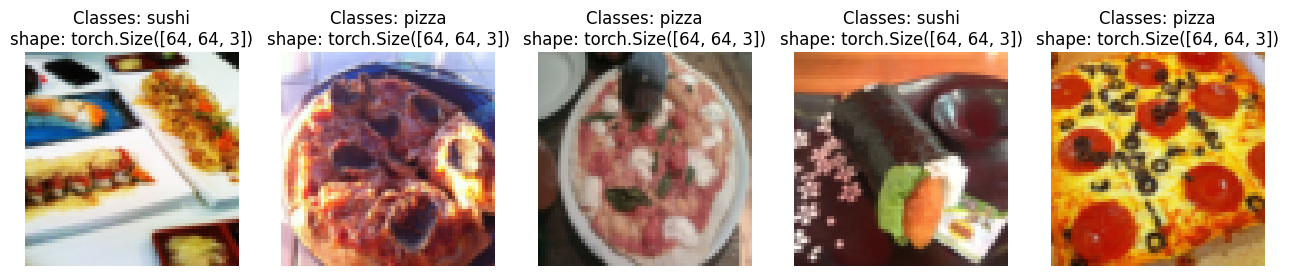

In [35]:
# Display random images from the ImageFolder created data
display_random_images(train_data,
                      n=5,
                      classes=class_names,
                      seed=42)

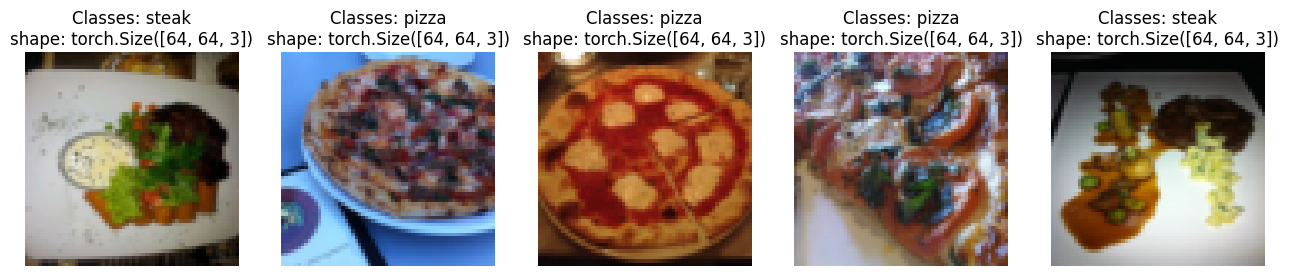

In [36]:
# Display random images from ImagesFolderCustom dataset
display_random_images(train_data_custom,
                      class_names,
                      n=5,
                      seed=None)

### 5.4 Turn the custom datset into `DataLoader`

In [37]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=0,
                                     shuffle=True)

test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                    batch_size=BATCH_SIZE,
                                    num_workers=0)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7a21e9699a10>,
 <torch.utils.data.dataloader.DataLoader at 0x7a21e9434850>)

In [38]:
# getting a single sample from custom dataloader
img_custom, label_custom = next(iter(train_dataloader_custom))
img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

## 6. Other forms of Transform - Data Augmentation

Data augmentation is the process of artificially adding diversity to your training data.

In this case of image data, this may mean applying various image transformations to the training images

This practice makes models more generalisable to unseen data

We should take a look at one particular type of data augmentation used to train PyTorch vision models to state of the art levels

In [39]:
# Taking a look at trivial augment
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])

In [40]:
image_path

PosixPath('data/pizza_steak_sushi')

In [41]:
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/train/sushi/2021381.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/773725.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/2574453.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/855721.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/2017378.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/2980779.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/1209865.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/390178.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/542188.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/710379.jpg')]

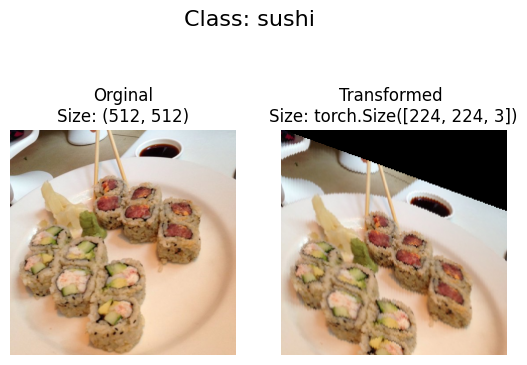

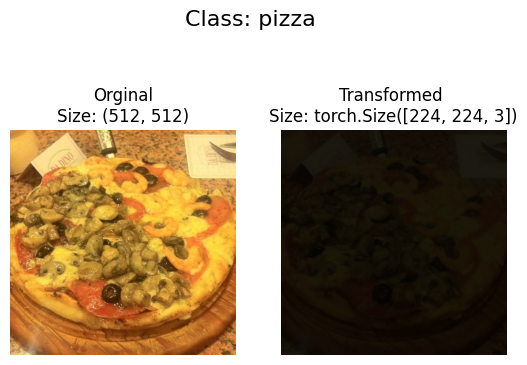

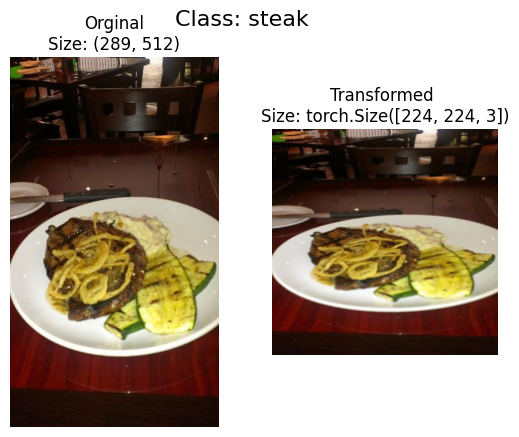

In [42]:
# plot random transformed images
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transform,
    n=3,
    seed=None
)

## 7. Model0: TinyVGG without data augmentation

Replicating TinyVGG architecture from CNN explainer website

### 7.1 Creating transforms and loading data into model0

In [44]:
# Create simple transform
simple_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
]) # Simplest transform

In [46]:
# 1. Load data and transform
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transform)

test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=simple_transform)

# 2. Turn data into dataloaders
import os
from torch.utils.data import DataLoader

# Setup hyperparameters
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# Create Dataloaders
train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=True)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=False)


(<torch.utils.data.dataloader.DataLoader at 0x7a21de4760d0>,
 2)

### 7.2 Create TinyVGG model class

In [81]:
# Buidling the model architecture
class TinyVGG(nn.Module):
  """
  Model architecture copied from CNN explainer
  """
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
    super().__init__()
    self.conv_layer_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2) # default stride value is same as kernel size for MaxPool
    )

    self.conv_layer_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2) # default stride value is same as kernel size for MaxPool
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units * 13 * 13,
                  out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_layer_1(x)
    # print(x.shape)
    x = self.conv_layer_2(x)
    # print(x.shape)
    x = self.classifier(x)
    # print(x.shape)
    return x
    # return self.classifier(self.conv_layer_2(self.conv_layer_1(x))) # benefits from operator fusion https://horace.io/brrr_intro.html

In [82]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3,
                 hidden_units=10,
                 output_shape=len(class_names)).to(device)
model_0

TinyVGG(
  (conv_layer_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

 ### 7.3 Trying forward pass on single image(to test the model)

 Passing dummy data to figure out correct shape for Linear layer in Classifier.


In [83]:
# Get a single image batch
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [84]:
# Tru=y forward pass
model_0(image_batch.to(device))

tensor([[ 2.0795e-02, -1.9510e-03,  9.5212e-03],
        [ 1.8440e-02,  2.4669e-03,  6.6609e-03],
        [ 1.7695e-02,  1.0282e-03,  9.4975e-03],
        [ 2.4446e-02, -3.3489e-03,  9.5877e-03],
        [ 1.9939e-02,  6.9129e-04,  1.0778e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 2.0996e-02,  1.6417e-04,  1.2481e-02],
        [ 2.1566e-02, -1.9607e-03,  9.7175e-03],
        [ 2.4500e-02, -4.7904e-03,  8.5394e-03],
        [ 2.0239e-02, -4.7980e-04,  1.0907e-02],
        [ 2.2219e-02, -4.1815e-04,  9.8173e-03],
        [ 2.2318e-02, -2.1642e-03,  9.4428e-03],
        [ 2.1851e-02, -3.7225e-03,  8.3784e-03],
        [ 2.2881e-02, -1.7559e-03,  1.0299e-02],
        [ 2.1635e-02, -4.3994e-03,  9.4990e-03],
        [ 2.2101e-02, -4.1469e-03,  9.3904e-03],
        [ 2.1226e-02, -4.4215e-03,  1.1476e-02],
        [ 2.1698e-02, -2.7458e-03,  8.4966e-03],
        [ 1.9974e-02, -3.2317e-07,  8.4496e-03],
        [ 1.8308e-02,  1.6378e-03,  8.5491e-03],
        [ 2.0768e-02

### 7.4 Use `torchinfo` to get idea of the shapes going through our model

In [85]:
# Install torchinfo and import it
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model_0, input_size = [1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia